<a href="https://colab.research.google.com/github/AndreaKarlova/censored_regressors/blob/main/real_world_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uq gpytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 2.2 MB/s eta 0:00:00


In [2]:
!pip install -Uq botorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 625.0/625.0 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 8.8 MB/s eta 0:00:00


In [3]:
!rm -rf censored_regressors
!git clone https://github.com/AndreaKarlova/censored_regressors.git

Cloning into 'censored_regressors'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (176/176), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 176 (delta 82), reused 119 (delta 34), pack-reused 0
Receiving objects: 100% (176/176), 33.54 MiB | 24.15 MiB/s, done.
Resolving deltas: 100% (82/82), done.


In [1]:
import tqdm
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
import math
from numbers import Number, Real

import botorch
import torch
from torch.distributions import constraints
from torch.distributions.exp_family import ExponentialFamily
from torch.distributions.utils import _standard_normal, broadcast_all

import importlib
from censored_regressors.src.censored_normal import CensoredNormal
from censored_regressors.src.censored_likelihood import CensoredGaussianLikelihood, CensoredGaussianLikelihoodAnalytic, CensoredGaussianLikelihoodMathematica

In [3]:
import warnings
from typing import Any

import torch
from linear_operator.operators import LinearOperator, ZeroLinearOperator
from torch import Tensor
from torch.distributions import Distribution, Normal

from gpytorch.constraints import Interval
from gpytorch.distributions import base_distributions, MultivariateNormal
from gpytorch.priors import Prior
from gpytorch.utils.warnings import GPInputWarning
from gpytorch.likelihoods.likelihood import _Likelihood, _OneDimensionalLikelihood

In [4]:
import pandas as pd
from gpytorch.models import ApproximateGP # handles basic variational inference
from gpytorch.variational import MeanFieldVariationalDistribution, CholeskyVariationalDistribution # distribution of the approximation q(f)
from gpytorch.variational import VariationalStrategy # use when larger sample - transform q(u) to q(f) over inducing points

class GPModel(ApproximateGP):
    def __init__(self, inducing_points, covariance_type='cholesky', kernel='rbf'):
        # defines approximation
        if covariance_type == 'cholesky':
          variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        elif covariance_type == 'mean_field':
          variational_distribution = MeanFieldVariationalDistribution(inducing_points.size(0))
        else:
          raise ValueError("Unknown covariance_type.")
        variational_strategy = VariationalStrategy(self, inducing_points,
                                                   variational_distribution, learn_inducing_locations=False)
        super(GPModel, self).__init__(variational_strategy)
        # defines the GP prior
        self.mean_module = gpytorch.means.ConstantMean()
        if kernel == 'rbf':
          self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        elif kernel == 'matern':
          self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())

    def forward(self, x):
        # for line in traceback.format_stack():
        #   print(line.strip())
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Dataset 1: Credit Risk

In [45]:
df = pd.read_csv('https://github.com/square/pysurvival/raw/master/pysurvival/datasets/credit_risk.csv')

Text(0.5, 1.0, 'Histogram')

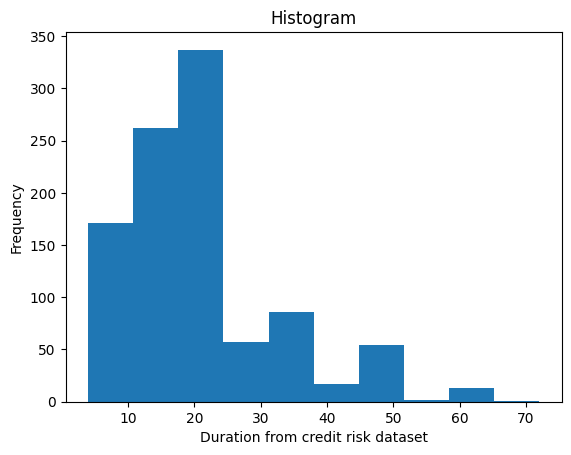

In [46]:
ax = df['duration'].plot(kind='hist')
ax.set_xlabel("Duration from credit risk dataset")
ax.set_title('Histogram')

In [47]:
category_columns = [
    'checking_account_status', 'credit_history', 'purpose',
    'savings_account_status', 'employment_years', 'personal_status',
    'other_debtors', 'property', 'other_installment_plans', 'housing', 'job']
dataset = pd.get_dummies(df, columns=category_columns, drop_first=True)

# Creating the time and event columns
time_column = 'duration'
event_column = 'full_repaid'

# Creating the features
features = np.setdiff1d(dataset.columns, [time_column, event_column] ).tolist()

In [48]:
# Checking for null values
N_null = sum(dataset[features].isnull().sum())
print("The raw_dataset contains {} null values".format(N_null)) #0 null values

# Removing duplicates if there exist
N_dupli = sum(dataset.duplicated(keep='first'))
dataset = dataset.drop_duplicates(keep='first').reset_index(drop=True)
print("The raw_dataset contains {} duplicates".format(N_dupli))

# Number of samples in the dataset
N = dataset.shape[0]

The raw_dataset contains 0 null values
The raw_dataset contains 0 duplicates


In [49]:
from sklearn.model_selection import train_test_split

to_remove = ['credit_history_existing_credit_paid', 'housing_own']
features = np.setdiff1d(features, to_remove).tolist()
index_train, index_test = train_test_split( range(N), test_size = 0.4)
data_train = dataset.loc[index_train].reset_index( drop = True )
data_test  = dataset.loc[index_test].reset_index( drop = True )

# Creating the X, T and E inputs
X_train, X_test = data_train[features], data_test[features]
T_train, T_test = data_train[time_column], data_test[time_column]
E_train, E_test = data_train[event_column], data_test[event_column]

## Censored Regressor

In [51]:
x = torch.FloatTensor(X_train.values.astype(np.float32))
y = torch.FloatTensor(T_train)
MIN_VALUE, MAX_VALUE = y.min(), 100.

censored_model = GPModel(inducing_points=x, covariance_type='cholesky')
censored_likelihood = CensoredGaussianLikelihoodAnalytic(low=MIN_VALUE-1e-6, high=MAX_VALUE+1e-6,
                                                              alpha=1., gamma=1., dzeta=1.)

if torch.cuda.is_available():
    censored_model = censored_model.cuda()
    censored_likelihood = censored_likelihood.cuda()

lmbd = 4 # lmbd in [1,10], 1 -> very linear, 10 -> very non-linear
kappa = 3 # kappa in [2,100], this is the signal to noise ratio. kappa = 2 -> signal = 2*noise
# censored_model.covar_module.base_kernel.initialize(lengthscale=x.std()/lmbd)
censored_model.covar_module.initialize(outputscale=y.var());
censored_model.mean_module.initialize(constant=y.mean())
censored_likelihood.noise.initialize(noise=(y.std()/kappa).square());

censored_model.train()
censored_likelihood.train()
censored_model.train_inputs = (x,)
censored_model.train_targets = y
mll = gpytorch.mlls.VariationalELBO(censored_likelihood, censored_model, num_data=y.size(0))
res = botorch.fit.fit_gpytorch_mll_scipy(mll)
print(res)


OptimizationResult(step=87, fval=3.611569404602051, status=<OptimizationStatus.SUCCESS: 2>, runtime=32.21549607399902, message='CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH')


### Evaluate on training data

In [52]:
censored_model.eval()
censored_likelihood.eval()
with gpytorch.settings.num_likelihood_samples(200):
  censored_posterior_f = censored_model(x)
  censored_posterior_y = censored_likelihood(censored_posterior_f)
expected_y_pred = censored_posterior_y.sample_n(200).mean([0,1])
print('Log prob of training data:', censored_posterior_y.log_prob(y).mean())
print('MAE of training data:', (expected_y_pred - y).abs().mean())

/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:179: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn(


Log prob of training data: tensor(-4.6526, grad_fn=<MeanBackward0>)
MAE of training data: tensor(1.0412)


In [ ]:
print('MAE of training data (censored):', (expected_y_pred - y)[y == y.max()].abs().mean())

MAE of training data (censored): tensor(3.5917)


### Evaluate on test data

In [53]:
# Test data
domain = torch.FloatTensor(X_test.values.astype(np.float32))
y_test = torch.FloatTensor(T_test)


with gpytorch.settings.num_likelihood_samples(200):
  censored_posterior_f = censored_model(domain)
  censored_posterior_y = censored_likelihood(censored_posterior_f)
expected_y_pred = censored_posterior_y.sample_n(200).mean([0,1])

print('Log prob of test data:', censored_posterior_y.log_prob(y_test).mean())
print('MAE of test data:', (expected_y_pred - y_test).abs().mean())
print('MSE of test data:', (expected_y_pred - y_test).square().mean())

/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:179: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn(


Log prob of test data: tensor(-25.3787, grad_fn=<MeanBackward0>)
MAE of test data: tensor(9.5663)
MSE of test data: tensor(155.1663)


Set up copy for likelihood surgery later

In [55]:
import copy
censored_likelihood_replacement = copy.deepcopy(censored_likelihood)

## Uncensored Regressor

In [56]:
x = torch.FloatTensor(X_train.values.astype(np.float32))
y = torch.FloatTensor(T_train)
# MIN_VALUE, MAX_VALUE = y.min(), 72.

uncensored_model = GPModel(inducing_points=x, covariance_type='cholesky')
lmbd = 4 # lmbd in [1,10], 1 -> very linear, 10 -> very non-linear
kappa = 3 # kappa in [2,100], this is the signal to noise ratio. kappa = 2 -> signal = 2*noise
# uncensored_model.covar_module.base_kernel.initialize(lengthscale=x.std()/lmbd)
uncensored_model.covar_module.initialize(outputscale=y.var());
uncensored_model.mean_module.initialize(constant=y.mean())
uncensored_likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_prior=gpytorch.priors.NormalPrior(loc=(y.std()/kappa).square(), scale=1))
# uncensored_likelihood.noise.initialize(noise=(y.std()/kappa).square());

if torch.cuda.is_available():
    uncensored_model = uncensored_model.cuda()
    uncensored_likelihood = uncensored_likelihood.cuda()


uncensored_model.train()
uncensored_likelihood.train()
uncensored_model.train_inputs = (x,)
uncensored_model.train_targets = y
mll = gpytorch.mlls.VariationalELBO(uncensored_likelihood, uncensored_model, num_data=y.size(0))
res = botorch.fit.fit_gpytorch_mll_scipy(mll)
print(res)


OptimizationResult(step=35, fval=3.8981165885925293, status=<OptimizationStatus.SUCCESS: 2>, runtime=12.414356868999675, message='CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL')
Log prob of training data: tensor(-1587.6707, grad_fn=<MeanBackward0>)
MAE of training data: tensor(1.0385, grad_fn=<MeanBackward0>)


### Evaluate on training data


uncensored_model.eval()
uncensored_likelihood.eval()

uncensored_posterior_f = uncensored_model(x)
uncensored_posterior_y = uncensored_likelihood(uncensored_posterior_f)
print('Log prob of training data:', uncensored_posterior_y.log_prob(y).mean())
print('MAE of training data:', (uncensored_posterior_y.loc - y).abs().mean())

### Evaluate on test data

In [57]:
domain = torch.FloatTensor(X_test.values.astype(np.float32))
y_test = torch.FloatTensor(T_test)

uncensored_posterior_f = uncensored_model(domain)
uncensored_posterior_y = uncensored_likelihood(censored_posterior_f)

print('Log prob of test data:', uncensored_posterior_y.log_prob(y_test).mean())
print('MAE of test data:', (uncensored_posterior_y.loc - y_test).abs().mean())

Log prob of test data: tensor(-1603.4954, grad_fn=<MeanBackward0>)
MAE of test data: tensor(9.5690, grad_fn=<MeanBackward0>)


### Likelihood surgery

In [58]:
censored_likelihood_replacement.noise.noise = uncensored_likelihood.noise
print('Check noise replacement: ',
      uncensored_likelihood.noise.detach().numpy(),
      censored_likelihood_replacement.variance.detach().numpy(),
      censored_likelihood.variance.detach().numpy())

censored_posterior_y = censored_likelihood(censored_posterior_f)
uncensored_posterior_y_diff_lik = censored_likelihood_replacement(uncensored_posterior_f)

# print('Censored NLPD: ', -censored_posterior_y.log_prob(y_test).mean())
print('Uncensored NLPD: ', -uncensored_posterior_y_diff_lik.log_prob(y_test).mean())

Check noise replacement:  [15.792379] [15.792379] [8.529441]
Censored NLPD:  tensor(24.9924, grad_fn=<NegBackward0>)
Uncensored NLPD:  tensor(11.1385, grad_fn=<NegBackward0>)


# Dataset 2: Survival analysis

In [5]:
!wget https://github.com/jaredleekatzman/DeepSurv/raw/master/experiments/data/gbsg/gbsg_cancer_train_test.h5

--2024-05-21 13:57:31--  https://github.com/jaredleekatzman/DeepSurv/raw/master/experiments/data/gbsg/gbsg_cancer_train_test.h5
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jaredleekatzman/DeepSurv/master/experiments/data/gbsg/gbsg_cancer_train_test.h5 [following]
--2024-05-21 13:57:31--  https://raw.githubusercontent.com/jaredleekatzman/DeepSurv/master/experiments/data/gbsg/gbsg_cancer_train_test.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86592 (85K) [application/octet-stream]
Saving to: ‘gbsg_cancer_train_test.h5.2’

gbsg_cancer_train_t 100%[===================>]  84.56K  --.-KB/s  

In [6]:
import h5py
from collections import defaultdict
datasets = defaultdict(dict)
with h5py.File("gbsg_cancer_train_test.h5", 'r') as fp:
    for ds in fp:
        for array in fp[ds]:
            datasets[ds][array] = fp[ds][array][:]

In [7]:
{k: v.shape for k,v in datasets['train'].items()}

{'e': (1546,), 't': (1546,), 'x': (1546, 7)}

Text(0.5, 1.0, 'Histogram')

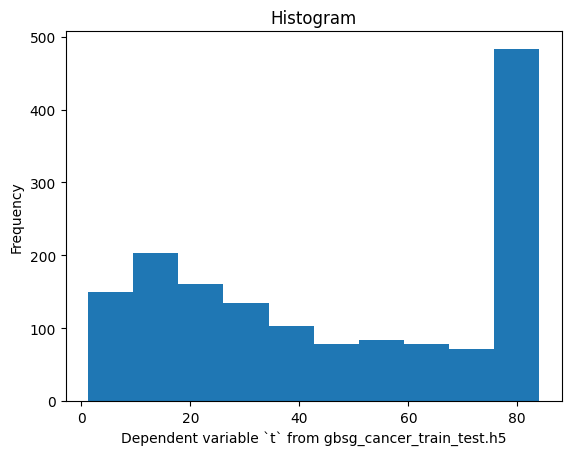

In [8]:
ax = pd.Series(datasets['train']['t']).plot(kind='hist')
ax.set_xlabel("Dependent variable `t` from gbsg_cancer_train_test.h5")
ax.set_title("Histogram")

Text(0.5, 1.0, 'Histogram')

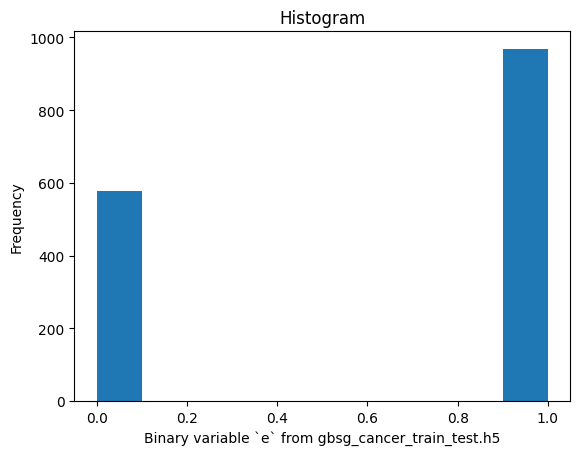

In [12]:
ax = pd.Series(datasets['train']['e']).plot(kind='hist')
ax.set_xlabel("Binary variable `e` from gbsg_cancer_train_test.h5")
ax.set_title("Histogram")

In [40]:
# previous [0, 100]
model_rbf, likelihood_rbf = censored_model, censored_likelihood

## Censored Regressor

In [41]:
x = torch.FloatTensor(datasets['train']['x'])
y = torch.FloatTensor(datasets['train']['t'])
MIN_VALUE, MAX_VALUE = 0, 88

censored_model = GPModel(inducing_points=x, covariance_type='cholesky', kernel='matern')
censored_likelihood = CensoredGaussianLikelihoodAnalytic(low=MIN_VALUE-1e-6, high=MAX_VALUE+1e-6,
                                                              alpha=1., gamma=1., dzeta=1.)

if torch.cuda.is_available():
    censored_model = censored_model.cuda()
    censored_likelihood = censored_likelihood.cuda()

lmbd = 4 # lmbd in [1,10], 1 -> very linear, 10 -> very non-linear
kappa = 10 # kappa in [2,100], this is the signal to noise ratio. kappa = 2 -> signal = 2*noise
# censored_model.covar_module.base_kernel.initialize(lengthscale=x.std()/lmbd)
censored_model.covar_module.initialize(outputscale=y.var());
censored_model.mean_module.initialize(constant=y.mean())
censored_likelihood.noise.initialize(noise=(y.std()/kappa).square());

censored_model.train()
censored_likelihood.train()
censored_model.train_inputs = (x,)
censored_model.train_targets = y
mll = gpytorch.mlls.VariationalELBO(censored_likelihood, censored_model, num_data=y.size(0))
res = botorch.fit.fit_gpytorch_mll_scipy(mll)
print(res)

OptimizationResult(step=31, fval=3.905782699584961, status=<OptimizationStatus.SUCCESS: 2>, runtime=458.13182784699893, message='CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH')


### Evaluate on training data

In [42]:
censored_model.eval()
censored_likelihood.eval()
with gpytorch.settings.num_likelihood_samples(200):
  censored_posterior_f = censored_model(x)
  censored_posterior_y = censored_likelihood(censored_posterior_f)
expected_y_pred = censored_posterior_y.sample_n(200).mean([0,1])
print('Log prob of training data:', censored_posterior_y.log_prob(y).mean())
print('MAE of training data:', (expected_y_pred - y).abs().mean())

/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:179: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn(


Log prob of training data: tensor(-5.3203, grad_fn=<MeanBackward0>)
MAE of training data: tensor(2.9438)


### Evaluate on test data

In [44]:
# Test data
domain = torch.FloatTensor(datasets['test']['x'])
y_test = torch.FloatTensor(datasets['test']['t'])

with gpytorch.settings.num_likelihood_samples(200):
  censored_posterior_f = censored_model(domain)
  censored_posterior_y = censored_likelihood(censored_posterior_f)
expected_y_pred = censored_posterior_y.sample_n(200).mean([0,1])

print('Log prob of test data:', censored_posterior_y.log_prob(y_test).mean())
print('MAE of test data:', (expected_y_pred - y_test).abs().mean())
print('MSE of test data:', (expected_y_pred - y_test).square().mean())

Log prob of test data: tensor(-17.8265, grad_fn=<MeanBackward0>)
MAE of test data: tensor(21.1881)
MSE of test data: tensor(614.4673)


## Uncensored Regressor

In [26]:
x = torch.FloatTensor(datasets['train']['x'])
y = torch.FloatTensor(datasets['train']['t'])
MIN_VALUE, MAX_VALUE = 0, 100

uncensored_model = GPModel(inducing_points=x, covariance_type='cholesky')
lmbd = 4 # lmbd in [1,10], 1 -> very linear, 10 -> very non-linear
kappa = 5 # kappa in [2,100], this is the signal to noise ratio. kappa = 2 -> signal = 2*noise
# uncensored_model.covar_module.base_kernel.initialize(lengthscale=x.std()/lmbd)
uncensored_model.covar_module.initialize(outputscale=y.var());
uncensored_model.mean_module.initialize(constant=y.mean())
uncensored_likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_prior=gpytorch.priors.NormalPrior(loc=(y.std()/kappa).square(), scale=1))
# uncensored_likelihood.noise.initialize(noise=(y.std()/kappa).square());

if torch.cuda.is_available():
    uncensored_model = uncensored_model.cuda()
    uncensored_likelihood = uncensored_likelihood.cuda()


uncensored_model.train()
uncensored_likelihood.train()
uncensored_model.train_inputs = (x,)
uncensored_model.train_targets = y
mll = gpytorch.mlls.VariationalELBO(uncensored_likelihood, uncensored_model, num_data=y.size(0))
res = botorch.fit.fit_gpytorch_mll_scipy(mll)
print(res)



OptimizationResult(step=29, fval=4.92753791809082, status=<OptimizationStatus.SUCCESS: 2>, runtime=258.689208482, message='CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH')
Log prob of training data: tensor(-4240.1587, grad_fn=<MeanBackward0>)
MAE of training data: tensor(0.7827, grad_fn=<MeanBackward0>)


### Evaluate on training data

In [ ]:
uncensored_model.eval()
uncensored_likelihood.eval()

uncensored_posterior_f = uncensored_model(x)
uncensored_posterior_y = uncensored_likelihood(uncensored_posterior_f)
print('Log prob of training data:', uncensored_posterior_y.log_prob(y).mean())
print('MAE of training data:', (uncensored_posterior_y.loc - y).abs().mean())

### Evaluate on test data

In [40]:
domain = torch.FloatTensor(datasets['test']['x'])
y_test = torch.FloatTensor(datasets['test']['t'])

uncensored_posterior_f = uncensored_model(domain)
uncensored_posterior_y = uncensored_likelihood(censored_posterior_f)

# print('Log prob of test data:', uncensored_posterior_y.log_prob(y_test).mean())
print('MAE of test data:', (uncensored_posterior_y.loc - y_test).abs().mean())
print('MSE of test data:', (uncensored_posterior_y.loc - y_test).square().mean())

Log prob of test data: tensor(-3172.7085, grad_fn=<MeanBackward0>)
MAE of test data: tensor(19.8403, grad_fn=<MeanBackward0>)
MSE of test data: tensor(529.7117, grad_fn=<MeanBackward0>)


### Likelihood surgery

In [30]:
import copy
censored_likelihood_replacement = copy.deepcopy(censored_likelihood)

In [31]:
censored_likelihood_replacement.noise.noise = uncensored_likelihood.noise
print('Check noise replacement: ',
      uncensored_likelihood.noise.detach().numpy(),
      censored_likelihood_replacement.variance.detach().numpy(),
      censored_likelihood.variance.detach().numpy())

censored_posterior_y = censored_likelihood(censored_posterior_f)
uncensored_posterior_y_diff_lik = censored_likelihood_replacement(uncensored_posterior_f)

# print('Censored NLPD: ', -censored_posterior_y.log_prob(y_test).mean())
print('Uncensored NLPD: ', -uncensored_posterior_y_diff_lik.log_prob(y_test).mean())

Check noise replacement:  [17.461466] [17.461466] [44.32917]
Censored NLPD:  tensor(18.5854, grad_fn=<NegBackward0>)
Uncensored NLPD:  tensor(42.9532, grad_fn=<NegBackward0>)
